## Bottleneck Toy Example

We look at a toy example where we expect short bursts to out preform the greedy aceptance function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from itertools import product 
import networkx as nx

## Set up toy bottleneck graphs

In [2]:
## returns a bottle neck graph with two complete graphs (one positive scoring 
## and one negative scoring) connected by a path graph which scores highest on the endpoints and lowest in the center.
def bottle_neck_graph(k_size, p_size, score="w"):
    pos = nx.complete_graph(k_size)
    neg = nx.complete_graph(k_size)
    path = nx.path_graph(p_size)
    
    ## Set up weights on subgraphs
    for n in pos.nodes():
        pos.node[n][score] = random.uniform(0,10)
    for n in neg.nodes():
        neg.node[n][score] = random.uniform(-10,0)

    path_len = len(path.nodes)
    for n in range(int(np.ceil(path_len / 2))):
        path.node[n][score] = path.node[path_len-n-1][score] = -n
    
    ## merge graphs and add edges from path
    G = nx.disjoint_union_all([pos, path, neg])
    G.add_edges_from([(k_size-1,k_size), (k_size+p_size-1,k_size+p_size)])
    return G

In [90]:
G = bottle_neck_graph(10,5)

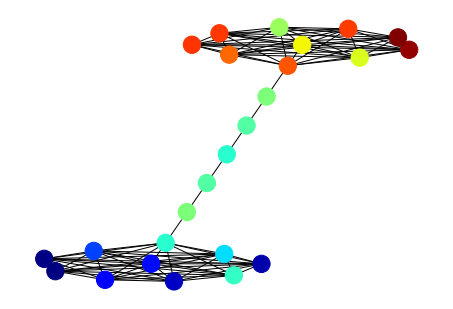

In [91]:
nx.draw_kamada_kawai(G, node_color=[G.node[n]["w"] for n in G.nodes], cmap="jet")
# plt.savefig("plots/bottleneck_graph.png")

In [3]:
H = bottle_neck_graph(20,7)

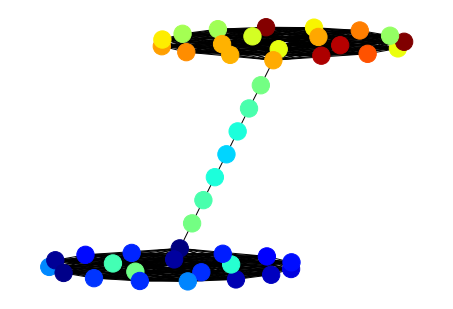

In [4]:
nx.draw_kamada_kawai(H, node_color=[H.node[n]["w"] for n in H.nodes], cmap="jet")

In [7]:
H_prime = bottle_neck_graph(20,11)

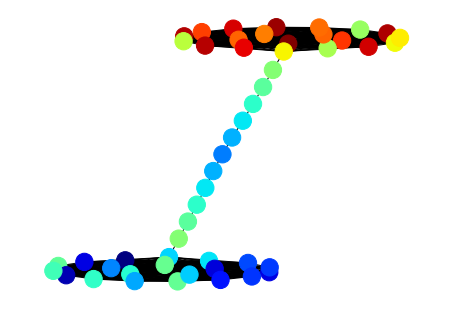

In [8]:
nx.draw_kamada_kawai(H_prime, node_color=[H_prime.node[n]["w"] for n in H_prime.nodes], cmap="jet")

## Set up optimiztion functions

In [10]:
## Random Walk on Graph:  Peform a random walk on graph `G` for `iters` steps, 
## starting at node `start_node`.  It returns an array of all the score atributes
## observed, and the node with the maximum score.
def random_walk(G, iters, score, start_node):
    rw = np.zeros(iters)
    rw[0] = G.node[start_node][score]
    cur_node = start_node
    max_node = start_node
    for i in range(1,iters):
        cur_node = np.random.choice(list(G.neighbors(cur_node)))
        rw[i] = G.node[cur_node][score]
        if rw[i] >= G.node[max_node][score]:
            max_node = cur_node
    return rw, max_node

In [11]:
## Tilted Run on Graph
def tilted_run(G, iters, score, start_node, p):
    tw = np.zeros(iters)
    tw[0] = G.node[start_node][score]
    cur_node = start_node
    max_node = start_node
    for i in range(1,iters):
        while True:
            proposal = np.random.choice(list(G.neighbors(cur_node)))
            if G.node[proposal][score] >= G.node[cur_node][score]: break
            if random.random() < p: break
        cur_node = proposal
        tw[i] = G.node[cur_node][score]
        if tw[i] >= G.node[max_node][score]:
            max_node = cur_node
    return tw, max_node

In [12]:
## Short Burst on Graph
def short_burst(G, burst_len, num_bursts, score, start_node):
    sb = np.zeros(burst_len*num_bursts)
    cur_node = start_node
    cur_max = start_node
    max_node = start_node
    
    for i in range(num_bursts):
        for j in range(burst_len):
            k = i*burst_len + j
            if j == 0:
                cur_node = cur_max
            else:
                cur_node = np.random.choice(list(G.neighbors(cur_node)))
                if G.node[cur_node][score] > G.node[cur_max][score]: cur_max = cur_node
            sb[k] = G.node[cur_node][score]
            if sb[k] >= G.node[max_node][score]:
                max_node = cur_node
    return sb, max_node

In [13]:
## Greedy Function on Graph
## Tilted Run on Graph
def greedy_run(G, iters, score, start_node):
    tw = np.zeros(iters)
    tw[0] = G.node[start_node][score]
    cur_node = start_node
    max_node = start_node
    for i in range(1,iters):
        proposal = np.random.choice(list(G.neighbors(cur_node)))
        if G.node[proposal][score] >= G.node[cur_node][score]: cur_node = proposal
        tw[i] = G.node[cur_node][score]
        if tw[i] >= G.node[max_node][score]:
            max_node = cur_node
    return tw, max_node

In [14]:
## Short Burst approach which doubles the burst lenght 
## if it has been stuck for stuck_buffer*burst length.
def variable_short_bursts(G, iters, score, start_node, stuck_buffer=10):
    sb = np.zeros(iters)
    burst_len = 2
    time_stuck = 0
    cur_node = start_node
    cur_max = start_node
    max_node = start_node
    k = 0
    
    while(k < iters):
        for j in range(burst_len):
            if j == 0: cur_node = cur_max
            else:
                cur_node = np.random.choice(list(G.neighbors(cur_node)))
                if G.node[cur_node][score] > G.node[cur_max][score]: cur_max = cur_node
            sb[k] = G.node[cur_node][score]
            
            if sb[k] <= G.node[max_node][score]: time_stuck += 1
            else: time_stuck = 0
                
            if sb[k] >= G.node[max_node][score]: max_node = cur_node
            k += 1
            if k >= iters: break
        if time_stuck >= stuck_buffer*burst_len : burst_len *= 2
    
    return sb, max_node, burst_len   

## Simulate functions on bottleneck graphs

In [6]:
def get_starting_point(G, score="w"):
    return np.argmin([G.node[n]["w"] for n in G.nodes])

### Small graph

In [93]:
N = 100
iters = 1600
start = get_starting_point(G)

In [94]:
rw = [random_walk(G, iters, "w", start) for n in range(N)]

In [95]:
tw = [tilted_run(G, iters, "w", start, 0.25) for n in range(N)]

In [96]:
# tw_8 = [tilted_run(H, 1000, "w", 15, 0.125) for n in range(N)]

In [97]:
gw = [greedy_run(G, iters, "w", start) for n in range(N)]

In [98]:
sb2 = [short_burst(G, 2, int(iters/2), "w", start) for n in range(N)]
sb5 = [short_burst(G, 5, int(iters/5), "w", start) for n in range(N)]
sb10 = [short_burst(G, 10, int(iters/10), "w", start) for n in range(N)]
sb20 = [short_burst(G, 20, int(iters/20), "w", start) for n in range(N)]
sb40 = [short_burst(G, 40, int(iters/40), "w", start) for n in range(N)]
sb100 = [short_burst(G, 100, int(iters/100), "w", start) for n in range(N)]

In [99]:
vsb5 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=5) for n in range(N)]
vsb10 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=10) for n in range(N)]
vsb20 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=20) for n in range(N)]
vsb40 = [variable_short_bursts(G, iters, "w", start, stuck_buffer=40) for n in range(N)]

In [85]:
min([r[2] for r in vsb5]), max([r[2] for r in vsb5])

(128, 256)

In [86]:
min([r[2] for r in vsb10]), max([r[2] for r in vsb10])

(64, 128)

In [87]:
min([r[2] for r in vsb20]), max([r[2] for r in vsb20])

(32, 64)

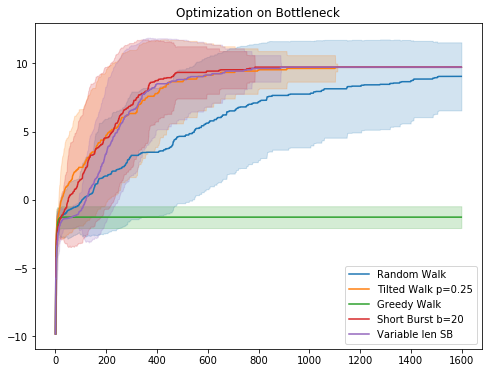

In [100]:
plt.figure(figsize=(8,6))
plt.title("Optimization on Bottleneck")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in rw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Random Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Tilted Walk p=0.25", ci="sd")
# sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_8]).flatten(), 
#              x=[i for i in range(1000)]*N, ci="sd", label="Tilted Walk p=0.125")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in gw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Greedy Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Short Burst b=20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")

plt.show()

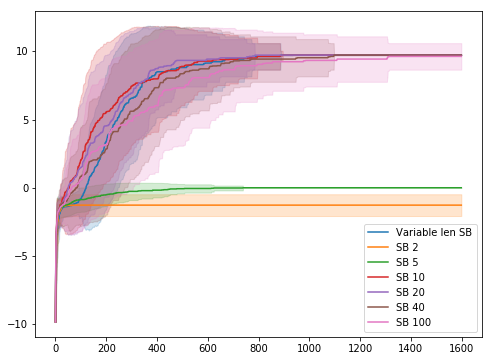

In [101]:
plt.figure(figsize=(8,6))

sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb2]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 2", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 40", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb100]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 100", ci="sd")

plt.show()

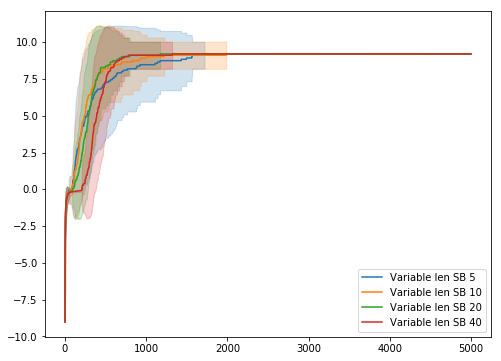

In [29]:
plt.figure(figsize=(8,6))
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 40", ci="sd")
plt.show()

KeyboardInterrupt: 

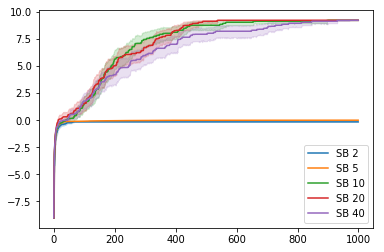

In [33]:
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb2]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 2")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb5]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 5")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb10]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 10")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb20]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 20")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb40]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 40")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0])[:1000] for r in sb100]).flatten(), 
             x=[i for i in range(1000)]*N, label="SB 100")

### larger graph

In [7]:
N = 100
iters = 2400
start = get_starting_point(H)

In [15]:
rw = [random_walk(H, iters, "w", start) for n in range(N)]
gw = [greedy_run(H, iters, "w", start) for n in range(N)]

In [16]:
tw4 = [tilted_run(H, iters, "w", start, 0.25) for n in range(N)]
tw8 = [tilted_run(H, iters, "w", start, 0.125) for n in range(N)]
tw16 = [tilted_run(H, iters, "w", start, 0.0625) for n in range(N)]

In [17]:
sb2 = [short_burst(H, 2, int(iters/2), "w", start) for n in range(N)]
sb5 = [short_burst(H, 5, int(iters/5), "w", start) for n in range(N)]
sb10 = [short_burst(H, 10, int(iters/10), "w", start) for n in range(N)]
sb20 = [short_burst(H, 20, int(iters/20), "w", start) for n in range(N)]
sb40 = [short_burst(H, 40, int(iters/40), "w", start) for n in range(N)]
sb100 = [short_burst(H, 100, int(iters/100), "w", start) for n in range(N)]

In [18]:
vsb5 = [variable_short_bursts(H, iters, "w", start, stuck_buffer=5) for n in range(N)]
vsb10 = [variable_short_bursts(H, iters, "w", start, stuck_buffer=10) for n in range(N)]
vsb20 = [variable_short_bursts(H, iters, "w", start, stuck_buffer=20) for n in range(N)]
vsb40 = [variable_short_bursts(H, iters, "w", start, stuck_buffer=40) for n in range(N)]

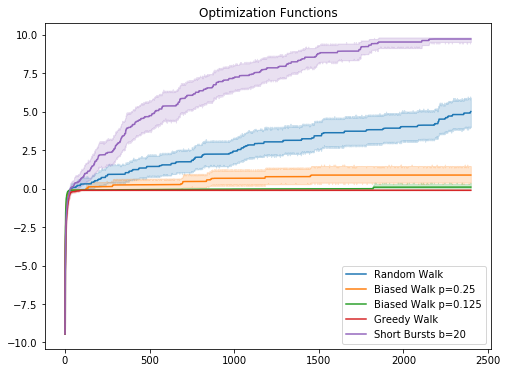

In [25]:
plt.figure(figsize=(8,6))
plt.title("Optimization Functions")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in rw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Random Walk")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw4]).flatten(), 
             x=[i for i in range(iters)]*N, label="Biased Walk p=0.25")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw8]).flatten(), 
             x=[i for i in range(iters)]*N, label="Biased Walk p=0.125")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in gw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Greedy Walk")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Short Bursts b=20")#, ci="sd")
# sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
#              x=[i for i in range(iters)]*N, label="Variable len SB")#, ci="sd")
plt.savefig("plots/bottle_neck/opt_functs_K20_P7_iters_2400.png", dpi=300, bbox_inches="tight")
plt.show()

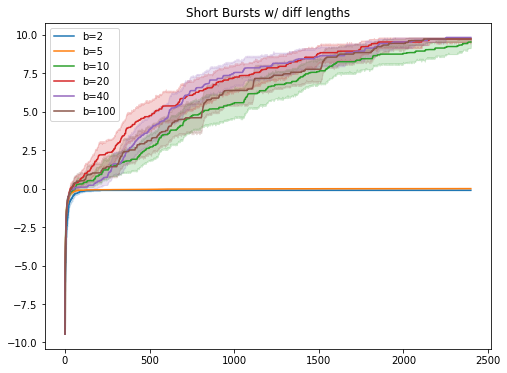

In [26]:
plt.figure(figsize=(8,6))
plt.title("Short Bursts w/ diff lengths")
# sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
#              x=[i for i in range(iters)]*N, label="Variable len SB")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb2]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=2")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=5")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=10")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=20")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=40")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb100]).flatten(), 
             x=[i for i in range(iters)]*N, label="b=100")#, ci="sd")
plt.savefig("plots/bottle_neck/burst_lengths_K20_P7_iters_2400.png", dpi=300, bbox_inches="tight")

plt.show()

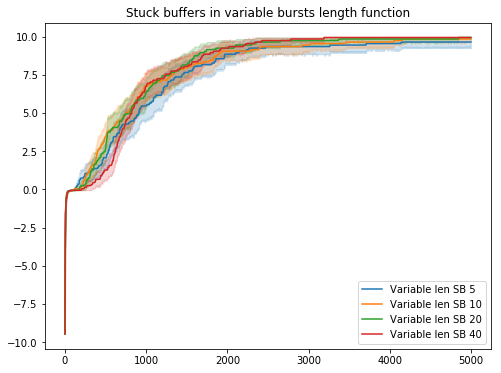

In [271]:
plt.figure(figsize=(8,6))
plt.title("Stuck buffers in variable bursts length function")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 5")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 10")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 20")#, ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 40")#, ci="sd")
plt.savefig("plots/bottle_neck/stuck_buffers_K20_P7.png")

plt.show()

In [28]:
N = 100
iters = 10000
start = get_starting_point(H_prime)

In [29]:
rw = [random_walk(H_prime, iters, "w", start) for n in range(N)]
tw = [tilted_run(H_prime, iters, "w", start, 0.25) for n in range(N)]
gw = [greedy_run(H_prime, iters, "w", start) for n in range(N)]

In [30]:
sb2 = [short_burst(H_prime, 2, int(iters/2), "w", start) for n in range(N)]
sb5 = [short_burst(H_prime, 5, int(iters/5), "w", start) for n in range(N)]
sb10 = [short_burst(H_prime, 10, int(iters/10), "w", start) for n in range(N)]
sb20 = [short_burst(H_prime, 20, int(iters/20), "w", start) for n in range(N)]
sb40 = [short_burst(H_prime, 40, int(iters/40), "w", start) for n in range(N)]
sb100 = [short_burst(H_prime, 100, int(iters/100), "w", start) for n in range(N)]

In [31]:
vsb5 = [variable_short_bursts(H_prime, iters, "w", start, stuck_buffer=5) for n in range(N)]
vsb10 = [variable_short_bursts(H_prime, iters, "w", start, stuck_buffer=10) for n in range(N)]
vsb20 = [variable_short_bursts(H_prime, iters, "w", start, stuck_buffer=20) for n in range(N)]
vsb40 = [variable_short_bursts(H_prime, iters, "w", start, stuck_buffer=40) for n in range(N)]

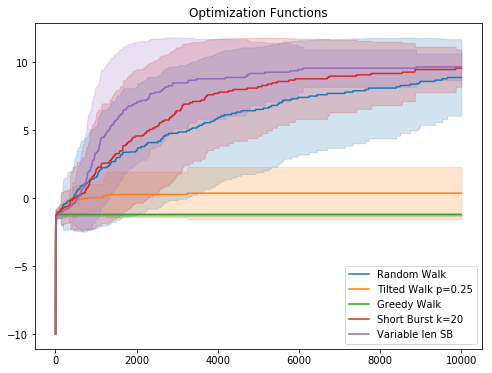

In [35]:
plt.figure(figsize=(8,6))
plt.title("Optimization Functions")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in rw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Random Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Tilted Walk p=0.25", ci="sd")
# sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in tw_8]).flatten(), 
#              x=[i for i in range(1000)]*N, ci="sd", label="Tilted Walk p=0.125")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in gw]).flatten(), 
             x=[i for i in range(iters)]*N, label="Greedy Walk", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Short Burst k=20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")
plt.savefig("plots/bottle_neck/opt_functs_K20_P11.png")
plt.show()

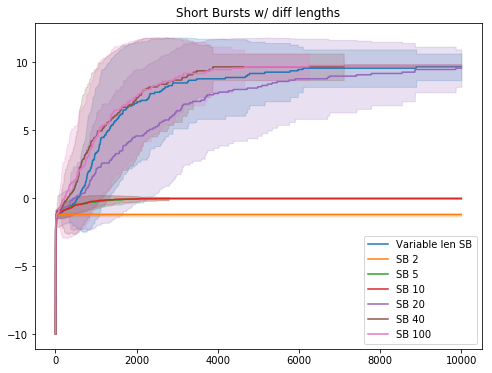

In [36]:
plt.figure(figsize=(8,6))
plt.title("Short Bursts w/ diff lengths")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb2]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 2", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 40", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in sb100]).flatten(), 
             x=[i for i in range(iters)]*N, label="SB 100", ci="sd")
plt.savefig("plots/bottle_neck/burst_lengths_K20_P11.png")

plt.show()

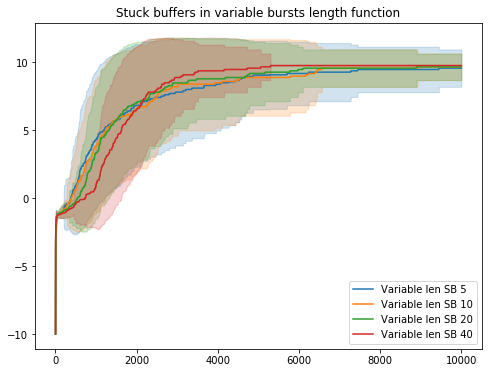

In [37]:
plt.figure(figsize=(8,6))
plt.title("Stuck buffers in variable bursts length function")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb5]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 5", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb10]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 10", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb20]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 20", ci="sd")
sns.lineplot(y = np.array([np.maximum.accumulate(r[0]) for r in vsb40]).flatten(), 
             x=[i for i in range(iters)]*N, label="Variable len SB 40", ci="sd")
plt.savefig("plots/bottle_neck/stuck_buffers_K20_P11.png")

plt.show()